# Workplace resources and willingness to speak out:

*a study of Mental Health in Tech by the Real Ricardo*

The data used in this notebook was downloaded from [Kaggle](https://www.kaggle.com/osmi/mental-health-in-tech-survey).


**Below is a description of the questions (columns) asked in the survey:**

| Column  | Description  |
|---|---|
| Timestamp  | Date survey was filled  |
| Gender  | Gender identity of surveyed person  |
| Country  | Country of residence  |
| State  | US residents only  |
| self_employed  | Are you self-employed?   |
| family_history  | Do you have a family history of mental illness?  |
| treatment  | Have you sought treatment for a mental health condition?  |
| work_interfere  | If you have a mental health condition, do you feel that it interferes with your work?  |
| no_employees  | How many employees does your company or organization have?  |
| remote_work  | Do you work remotely (outside of an office) at least 50% of the time?  |
| tech_company  | Is your employer primarily a tech company/organization?  |
| benefits  | Does your employer provide mental health benefits?  |
| care_options  | Do you know the options for mental health care your employer provides?  |
| wellness_program  | Has your employer ever discussed mental health as part of an employee wellness program?  |
| seek_help  | Does your employer provide resources to learn more about mental health issues and how to seek help?  |
| anonymity  | Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?  |
| leave  | How easy is it for you to take medical leave for a mental health condition?  |
| mental_health_consequence  | Do you think that discussing a mental health issue with your employer would have negative consequences?  |
| phys_health_consequence  | Do you think that discussing a physical health issue with your employer would have negative consequences?  |
| coworkers  | Would you be willing to discuss a mental health issue with your coworkers?  |
| supervisors  | Would you be willing to discuss a mental health issue with your direct supervisor(s)?  |
| mental_health_interview  | Would you bring up a mental health issue with a potential employer in an interview?  |
| mental_vs_physical  | Do you feel that your employer takes mental health as seriously as physical health?  |
| obs_consequence  | Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?  |
| comments  | Any additional notes or comments?  |

In [3]:
# classic importing of libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# choosing color palette
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

## 1. Data Cleaning

In [4]:
# loading data into pandas dataframe and exploring columns and first rows
survey = pd.read_csv('survey.csv')
survey.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [5]:
# renaming columns to have all lowercase
survey.columns = [col.lower() for col in survey.columns]

# looking at dtypes, we can see all of them are pandas objects except for age that is int.
print(survey.dtypes)

timestamp                    object
age                           int64
gender                       object
country                      object
state                        object
self_employed                object
family_history               object
treatment                    object
work_interfere               object
no_employees                 object
remote_work                  object
tech_company                 object
benefits                     object
care_options                 object
wellness_program             object
seek_help                    object
anonymity                    object
leave                        object
mental_health_consequence    object
phys_health_consequence      object
coworkers                    object
supervisor                   object
mental_health_interview      object
phys_health_interview        object
mental_vs_physical           object
obs_consequence              object
comments                     object
dtype: object


- **after exploring some of the columns I have decided not to use the *timestamp, country, state or comments columns*.**
- **i don't think there are is not enough data to do a geographical analysis.**

In [6]:
survey.drop(['timestamp', 'state', 'comments', 'country'], axis= 1, inplace= True)

In [7]:
# after finding some weird responses in the age column ('such as 99999999 and -1729')
# i decided to only include 'valid' numbers for age
survey['age'] = survey['age'].apply(lambda x: x if 0 < x < 100 else np.nan)

In [8]:
# gender is one big mess of data but I believe in myself.
# first lower case and strip eveything to decrease options
survey['gender'] = survey['gender'].apply(lambda x: x.lower().strip())

# based on the replies made these lists manually, I hope to not offend anyone.
male = ['male', 'm', 'make', 'cis male', 'man', 'cis man', 'msle', 'malr', 'mail', 'maile', 'something kinda male?', 'ostensibly male, unsure what that really means', 'male-ish', 'guy (-ish) ^_^', 'mal', 'male (cis)']
female = ['female', 'f', 'woman', 'female (cis)', 'cis-female/femme', 'femake', 'cis female', 'femail']

def regender(gender_input):
    
    """
    Input: a string about gender
    Output: male, female or other depending on our dictionary
    
    """ 
    if gender_input in male:
        return 'male'
    elif gender_input in female:
        return 'female'
    else:
        return 'other'
    
survey['gender'] = survey['gender'].apply(regender)

# check our final results
survey.gender.value_counts(dropna= False)

gender
male      994
female    247
other      18
Name: count, dtype: int64

In [9]:
# checking for nans
nan_cols = []
for col in survey.columns:
    if survey[col].isnull().sum():
        print(col + ' (%): ' + str(sum(survey[col].isnull())/len(survey)))
        nan_cols += [col]

# nans are present in the self-employed column and in the work_interfere column.
# at most there are 20% of values with nans so we'll replace with 'Don't know'
for col in nan_cols:
    survey[col].fillna("Don't know", inplace= True)

# i'm just gonna drop the rows without age.
survey = survey[survey.age != "Don't know"]

# in the context of our questions we need to drop everyone who is self-employed
print(survey['self_employed'].value_counts())
survey.loc[survey['self_employed'] == 'Yes'] = np.nan
survey.dropna(inplace=True)

age (%): 0.003971405877680699
self_employed (%): 0.014297061159650517
work_interfere (%): 0.2096902303415409
self_employed
No            1092
Yes            144
Don't know      18
Name: count, dtype: int64


- **it seems the rest of the columns are questions that might be yes or no, with few additional options**
- **we can identify that by checking the possible answers in each question**

In [10]:
# getting unique answers for every column
exclude = ['age']
possible_answers = {col:[i for i in survey[col].unique()] for col in survey.columns if col not in exclude}
possible_answers

{'gender': ['female', 'male', 'other'],
 'self_employed': ["Don't know", 'No'],
 'family_history': ['No', 'Yes'],
 'treatment': ['Yes', 'No'],
 'work_interfere': ['Often', 'Rarely', 'Never', 'Sometimes', "Don't know"],
 'no_employees': ['6-25',
  'More than 1000',
  '26-100',
  '100-500',
  '1-5',
  '500-1000'],
 'remote_work': ['No', 'Yes'],
 'tech_company': ['Yes', 'No'],
 'benefits': ['Yes', "Don't know", 'No'],
 'care_options': ['Not sure', 'No', 'Yes'],
 'wellness_program': ['No', "Don't know", 'Yes'],
 'seek_help': ['Yes', "Don't know", 'No'],
 'anonymity': ['Yes', "Don't know", 'No'],
 'leave': ['Somewhat easy',
  "Don't know",
  'Somewhat difficult',
  'Very difficult',
  'Very easy'],
 'mental_health_consequence': ['No', 'Maybe', 'Yes'],
 'phys_health_consequence': ['No', 'Yes', 'Maybe'],
 'coworkers': ['Some of them', 'No', 'Yes'],
 'supervisor': ['Yes', 'No', 'Some of them'],
 'mental_health_interview': ['No', 'Yes', 'Maybe'],
 'phys_health_interview': ['Maybe', 'No', 'Yes']

- **after looking at these answer possibilities want to normalize all 'half-answers' to 'Don't know', so changing 'Not sure' and 'Maybes'**
- **this decision might be open for interpretation, but I made a judgement call for the sake of consistency**

In [11]:
def replace_uncertainty(survey_answer):
    """
    Uniformizes all uncertain answers.
    Input: half-answer (string)
    Output: 'Don't know'
    
    """
    
    uncertainty = ['Maybe', 'Some of them', 'Not sure']
    if survey_answer in uncertainty:
        return "Don't know"
    else:
        return survey_answer

# apply function to all columns
for col in survey.columns:
    survey[col] = survey[col].apply(replace_uncertainty)

- **the column 'care_options' asks the question: "Do you know the options for mental health care your employer provides?" and about 30% of the answers are 'Dont know'.** 
- **in my opinion: if the answer to a question 'Do you know?' is 'I don't know' - then the answer is No.**

In [12]:
survey['care_options'] = survey['care_options'].replace(to_replace="Don't know", value= 'No')
survey['care_options'].value_counts()

care_options
No     730
Yes    380
Name: count, dtype: int64

## 2. Exploratory Data Analysis

**I was trying to come up with a question to ask the data but I wasn't feeling very creative.**
**So I'm gonna do an agnostic analysis and just make a correlation matrix bewteen all the variables.**

1. The first thing I'll do is encode all the answers as numbers.
- **Important notes:**
- All the half answers go in the middle (0)

In [13]:
# create a dictionary to map out all the answers in the survey
encoding_dict = {'No': -1, "Don't know": 0, 'Yes': 1,
                 'Never': -2, 'Rarely': -1, 'Sometimes': 1, 'Often': 2,
                 'Very difficult': -2, 'Somewhat difficult': -1, 'Somewhat easy': 1, 'Very easy': 2,
                 '1-5': 0, '6-25': 1, '26-100': 2, '100-500': 3, '500-1000': 4, 'More than 1000': 5,
                 'male': -1, 'other': 0, 'female': 1}

In [14]:
# made a copy just to check values
survey_coded = survey.copy()

# for each column except the ones not excluded change the values in our dictionary
for col in survey_coded.columns:
    if col not in exclude:
        survey_coded[col] = survey_coded[col].map(encoding_dict)

In [15]:
# let's take a look at our answer-encoded dataframe.
survey_coded

,age,gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37.0,1,0,-1,1,2,1,-1,1,1,...,1,1,-1,-1,0,1,-1,0,1,-1
1,44.0,-1,0,-1,-1,-1,5,-1,-1,0,...,0,0,0,-1,-1,-1,-1,-1,0,-1
2,32.0,-1,0,-1,-1,-1,1,-1,1,-1,...,0,-1,-1,-1,1,1,1,1,-1,-1
3,31.0,-1,0,1,1,2,2,-1,1,-1,...,-1,-1,1,1,0,-1,0,0,-1,1
4,31.0,-1,0,-1,-1,-2,3,1,1,1,...,0,0,-1,-1,0,1,1,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,26.0,-1,-1,-1,1,0,2,-1,1,-1,...,0,1,-1,-1,0,0,-1,-1,0,-1
1255,32.0,-1,-1,1,1,2,2,1,1,1,...,1,-1,-1,-1,0,1,-1,-1,1,-1
1256,34.0,-1,-1,1,1,1,5,-1,1,1,...,0,-1,1,1,-1,-1,-1,-1,-1,-1
1257,46.0,1,-1,-1,-1,0,3,1,1,-1,...,0,0,1,-1,-1,-1,-1,-1,-1,-1


- **because I'm still not feeling very creative, I'm gonna make a correlation matrix across all the variables in the study**

In [16]:
# make the correlation matrix
correlation = survey_coded.corr()

In [17]:
# making a mask to only show half the table cause its duplicated.
mask = np.triu(np.ones_like(correlation, dtype=np.bool))

# choosing colors
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, cmap=cmap, mask=mask, annot= False)

/tmp/ipykernel_6501/979018309.py:2: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  mask = np.triu(np.ones_like(correlation, dtype=np.bool))


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

- **This plot is very pretty but I've come to the realization that it is useless to me. there are way too many variables. It's hard to consider what is important or not and I don't have the know-how yet to disentangle all of this.**

*Teach me please.*

## 3. Hypothesis-driven analysis

**To create a score for the willingness to speak, we combined all the columns that ask 'If you're willing to speak to someone about mental health**

**Following the same logic, I combined all the columns that ask about services provided by the company**

We combined these columns by adding them together, it was important to make sure they all 'move in the same direction'
The result of this are two columns:
1. 'workplace_resources': with a possible value ranging from -6 to 6 and is the score of the company
2. 'willingness': with a possible values ranging from -3 to 3 and is the metric of the employee

In [ ]:
# define columns to combine
workplace_resources = ['benefits', 
                      'wellness_program', 
                      'anonymity', 
                      'seek_help', 
                      'leave']

willingness = ['coworkers',
               'supervisor',
               'mental_health_interview']

# add columns together
survey_coded['workplace_resources'] = survey_coded.benefits + survey_coded.wellness_program + survey_coded.seek_help + survey_coded.leave + survey_coded.anonymity
survey_coded['willingness'] = survey_coded.coworkers + survey_coded.supervisor + survey_coded.mental_health_interview

In [ ]:
# gonna define a function to make a nice looking histogram

def pretty_histogram(data, colname, label, save= False):
    
    """
    Input: data (pandas dataframe), column name (str), x label (str), save (bool)
    Output: a pretty histogram
    """

    hist = sns.distplot(data[colname], 
                        bins = data[colname].max() - data[colname].min() + 1,
                        kde= False,
                        color=flatui[-2],
                        hist_kws= {'range': (data[colname].min(), data[colname].max()),
                                   'rwidth': 0.95,
                                   'alpha': 1})
    
    hist.set(xlabel= label, ylabel= 'Count')
    sns.despine()
    
    if save:
        figure = hist.get_figure()
        figure.savefig('figures/' + colname + "_hist.png")
    

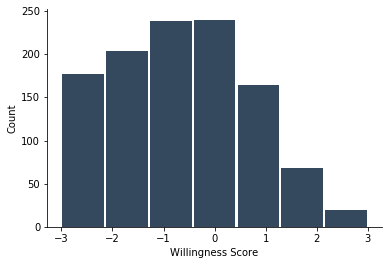

In [ ]:
# make a histogram for our newly created 'Willingness' variable.
pretty_histogram(survey_coded, 'willingness', 'Willingness Score', save= False)

**This looks like a right skewed distribution, meaning that the majority of people are unwilling to talk about mental health in their work environment.**

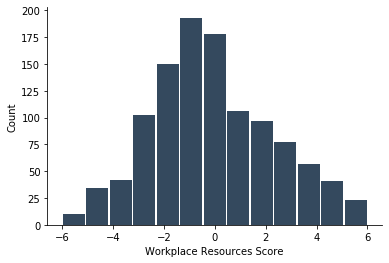

In [ ]:
# make a histogram for our newly created 'Workplace Resources' variable
pretty_histogram(survey_coded, 'workplace_resources', 'Workplace Resources Score', save= True)

**This one looks more normally distributed but still centered left of the zero, meaning that the majority of companies don't have many mental health resources**

#### Before moving forwards, one of the first questions we can ask is: does having more mental health services mean that your employees are aware these services exist?

In [ ]:
# interestingly to check the proportion of people aware of services I needed to recode the values in the
# care options column from 'No' = -1 to 'No' = 0
survey_coded['care_options'].replace(to_replace=-1, value=0, inplace= True)
survey_coded.pivot_table(index=['workplace_resources'], values=['care_options'], aggfunc= lambda x: sum(x)/len(x))

,care_options
workplace_resources,
-6,0.400000
-5,0.441176
-4,0.333333
-3,0.215686
-2,0.180000
-1,0.176166
0,0.252809
1,0.377358
2,0.432990


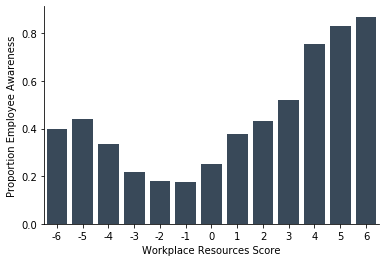

In [ ]:
# plot proportions of people that know about care options for each score of workplace resource.

label = 'Workplace Resources Score'

bars = sns.barplot(x='workplace_resources', y='care_options', data= survey_coded, 
                   ci= None, color= flatui[4])

bars.set(xlabel= label, ylabel= 'Proportion Employee Awareness')
sns.despine()
figure = bars.get_figure()
figure.savefig('figures/resources_and_awareness.png')

- **This is a really interesting result, kind of U-shaped.**
- **One possible interpretation is that the more services are available, more people know about them, and where there's none people ALSO know that.**

- **before moving on with our analysis, I would like to see what's the behavior of our willingness score according to some other variables, such as family history, treatment and work interfere**

In [ ]:
# group by variable of interest, create a label and rename columns
family_data = survey_coded.groupby('family_history').agg({'willingness':'mean'}).reset_index()
family_data['label'] = ['Family History']*len(family_data)
family_data.rename(columns= {'family_history':'Answer'}, inplace=True)

treatment_data = survey_coded.groupby('treatment').agg({'willingness':'mean'}).reset_index()
treatment_data['label'] = ['Treatment']*len(treatment_data)
treatment_data.rename(columns= {'treatment':'Answer'}, inplace=True)

willingness_variables = pd.concat([family_data, treatment_data], axis=0)
willingness_variables.Answer.replace(to_replace=-1, value='No', inplace=True)
willingness_variables.Answer.replace(to_replace=1, value='Yes', inplace=True)

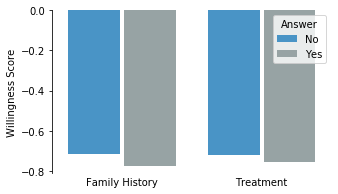

In [ ]:
# making a category bar plot
fig, ax = plt.subplots(figsize=(5, 3))

bars= sns.barplot(x="label", y="willingness", hue="Answer", 
            palette= sns.color_palette(flatui[1:3]), 
            data=willingness_variables)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


change_width(ax, .37)
sns.despine(bottom=True)
bars.set(xlabel= '', ylabel= 'Willingness Score')
bars.tick_params(axis='x', which='both', length=0)
figure = bars.get_figure()
figure.savefig('figures/history_treatment_willingness.png')

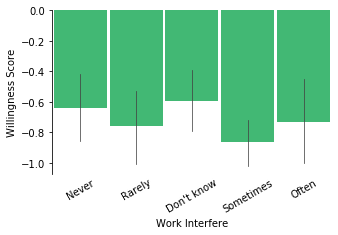

In [ ]:
xlabel = 'Work Interfere'
ylabel = 'Willingness Score'

fig, ax = plt.subplots(figsize=(5, 3))
bars = sns.barplot(x= 'work_interfere', y= 'willingness', data= survey_coded, color= flatui[-1], errwidth=0.75)

bars.set(xlabel= xlabel, ylabel= ylabel, xticklabels=['Never', 'Rarely', "Don't know", 'Sometimes', 'Often'])
bars.set_xticklabels(['Never', 'Rarely', "Don't know", 'Sometimes', 'Often'], rotation=30)
bars.set()
sns.despine(bottom= True)
change_width(ax, .95)
bars.tick_params(axis='x', which='both', length=0)

figure = bars.get_figure()
figure.savefig('figures/work_interfere_willingness.png')

In [ ]:
# I also did this analysis for gender but I find it slightly less interesting.
gender_willingness = survey_coded.groupby('gender').agg({'willingness':'mean'})
gender_willingness

,willingness
gender,
-1,-0.659404
0,-0.615385
1,-1.053333


- **contrary to expected, it seems that women are less likely to open up about mental health. However, upon further thinking, this might make sense if we consider that tech is a male-dominated industry where perhaps climbing up the ladder as a woman is significantly harder. in that case, they would be much more scared to bring up these issues and make their lives ever harder?**

In [ ]:
# to reach the answer to our main question
willingness_treatment = survey_coded.groupby('workplace_resources').agg({'willingness':'mean'})
willingness_treatment

,willingness
workplace_resources,
-6,-2.600000
-5,-1.323529
-4,-1.000000
-3,-1.333333
-2,-0.820000
-1,-0.782383
0,-0.752809
1,-0.641509
2,-0.453608


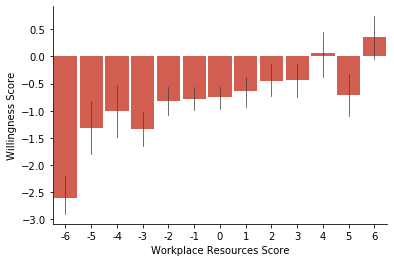

In [ ]:
# create a bar plot with the average willingness score for each workplace resourses category
xlabel = 'Workplace Resources Score'
ylabel = 'Willingness Score'

fig, ax = plt.subplots()
bars = sns.barplot(x='workplace_resources', y='willingness', data= survey_coded, 
                   color= flatui[3], errwidth=0.75)

bars.set(xlabel= xlabel, ylabel= ylabel)
sns.despine()
change_width(ax, .9)
figure = bars.get_figure()
figure.savefig('figures/resources_willingness.png')

- **it looks like the average willingness score goes up the more resources are available in the company! which is pretty cool**
- **to try and get some statistical power on this we took the raw data and tried to make a linear regression to see if we could predict the willing score of a person using workplace resources.**

In [ ]:
# linear regression
x = survey_coded['workplace_resources']
y = survey_coded['willingness']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print ('The slope is: ' + str(slope))
print ('The intercept is: ' + str(intercept))
print ('The r_value is: ' + str(r_value**2))
print ('The std error is: ' + str(std_err))
print(p_value)

The slope is: 0.1253597181423454
The intercept is: -0.7280097538526822
The r_value is: 0.044725026501352225
The std error is: 0.01740512006838772
1.090037487724972e-12


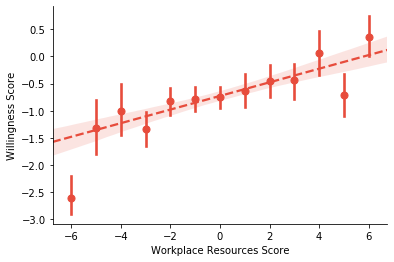

In [ ]:
xlabel = 'Workplace Resources Score'
ylabel = 'Willingness Score'
reg = sns.regplot(x, y, x_estimator=np.mean,
                  scatter_kws={'color':flatui[3]}, 
                  line_kws = {'color':flatui[3],
                              'ls':'dashed'})
reg.set(xlabel= xlabel, ylabel= ylabel)
sns.despine()
figure = reg.get_figure()
figure.savefig('figures/resources_willingness_regplot.png')

- **there doesn't seem to be a strong relationship between these variables BUT!**
- **Even though our model only explains a small amount of the variation, when you consider all the things that might affect behavior towards mental health, even a small effect should not be ignored.**